Import libraries

In [1]:
from google.colab import drive
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications import EfficientNetB3
import os
import seaborn as sns
import pydot
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization

Mount Drive with dataset

In [2]:
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/My Drive/AgeEstimAI/UTKFace')

Mounted at /content/gdrive


## Prepate UTKFace dataset

In [6]:
tf.random.set_seed(8520)
random.seed(8520)

BATCH_SIZE = 64
IMG_SIZE = 200

augment_images = True

data_dir = '/content/gdrive/My Drive/AgeEstimAI/UTKFace'
all_image_paths = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir)]
random.shuffle(all_image_paths)

In [5]:
def get_label(file_path):
    age = tf.strings.split(tf.strings.split(file_path, os.sep)[-1], '_')[0]
    return tf.strings.to_number(age, tf.int32)

data_augmentation = Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomContrast(0.3),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.2),
        layers.RandomBrightness(0.3),
        layers.RandomTranslation(height_factor=0.05, width_factor=0.05),
])

# Transform image path to image, label instance for the dataset
def process_path(file_path, augment=False):
    label = get_label(file_path)
    img = tf.image.decode_jpeg(tf.io.read_file(file_path), channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    if augment:
        img = data_augmentation(img)
    return img, label

# Filter ages and extract file paths
filtered_file_paths = []
ages = []
for file_path in all_image_paths:
    age = get_label(file_path)
    if 21 <= age <= 60:
        filtered_file_paths.append(file_path)
        ages.append(age)

# Stratified split (60/20/20) now: (70/10/20)
train_files, test_files, train_ages, test_ages = train_test_split(
    filtered_file_paths, ages, test_size=0.3, random_state=3420, stratify=ages)

val_files, test_files, val_ages, test_ages = train_test_split(
    test_files, test_ages, test_size=0.66, random_state=3420, stratify=test_ages)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(train_files).map(lambda x: process_path(x, augment=False))
if augment_images:
  augmented_dataset = tf.data.Dataset.from_tensor_slices(train_files).map(lambda x: process_path(x, augment=True))
  train_dataset = train_dataset.concatenate(augmented_dataset)
val_dataset = tf.data.Dataset.from_tensor_slices(val_files).map(lambda x: process_path(x, augment=False))
test_dataset = tf.data.Dataset.from_tensor_slices(test_files).map(lambda x: process_path(x, augment=False))

# Batch and prefetch
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

Show Batch

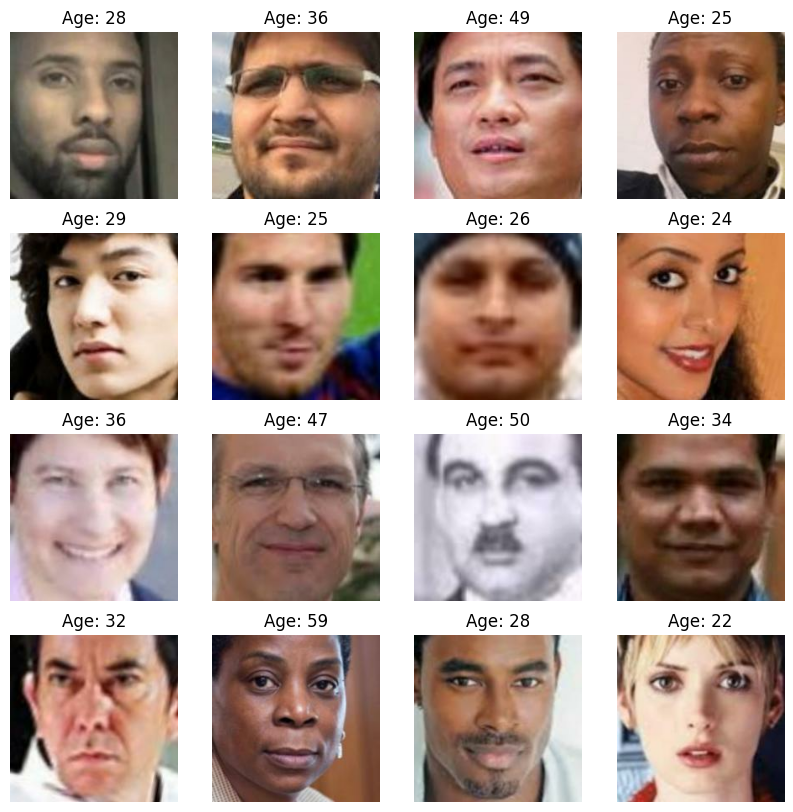

In [18]:
def show_batch(dataset):
    """Displays the first 16 images and their labels from a single batch."""
    for images, labels in dataset.take(1):
        plt.figure(figsize=(10, 10))
        for i in range(16):  # Display only the first 16 images
            ax = plt.subplot(4, 4, i + 1)  # Create a 4x4 grid
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Age: {labels[i].numpy()}")
            plt.axis("off")
        plt.show()

show_batch(val_dataset)

## EfficientNet

#### Checkpoint models and early stopping

The training is stopped early after 2 epoches without improvements on the validation set. The models are saved after each improvement to have the best model in end.

In [7]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=2,
    monitor='val_loss',
    mode='min',
    verbose=1,
    restore_best_weights=True
)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [8]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    #BatchNormalization(), # bn
    #layers.Dense(512), # bn
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    #BatchNormalization(), # bn
    layers.Dense(1, activation='linear')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.00007, decay_steps=500, decay_rate=0.75, staircase=False) # original: 0.0016

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = tf.keras.optimizers.RMSprop()

#model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])

# Train
#history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)
history = model.fit(train_dataset, epochs=8, validation_data=val_dataset,callbacks=[checkpoint_cb, early_stopping_cb])

model.save('/content/best_model_manual_save.h5')

16705208/16705208 [==============================] - 1s 0us/step
Epoch 1/8
362/362 [==============================] - ETA: 0s - loss: 9.9013 - mae: 10.3872
Epoch 1: val_loss improved from inf to 5.42328, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


362/362 [==============================] - 641s 2s/step - loss: 9.9013 - mae: 10.3872 - val_loss: 5.4233 - val_mae: 5.9054
Epoch 2/8
362/362 [==============================] - ETA: 0s - loss: 5.3747 - mae: 5.8536
Epoch 2: val_loss improved from 5.42328 to 5.24879, saving model to best_model.h5
362/362 [==============================] - 284s 786ms/step - loss: 5.3747 - mae: 5.8536 - val_loss: 5.2488 - val_mae: 5.7256
Epoch 3/8
362/362 [==============================] - ETA: 0s - loss: 4.9678 - mae: 5.4453
Epoch 3: val_loss improved from 5.24879 to 5.08332, saving model to best_model.h5
362/362 [==============================] - 284s 786ms/step - loss: 4.9678 - mae: 5.4453 - val_loss: 5.0833 - val_mae: 5.5632
Epoch 4/8
362/362 [==============================] - ETA: 0s - loss: 4.7071 - mae: 5.1834
Epoch 4: val_loss improved from 5.08332 to 5.03860, saving model to best_model.h5
362/362 [==============================] - 284s 786ms/step - loss: 4.7071 - mae: 5.1834 - val_loss: 5.0386 - va

Plot training and validation loss curve

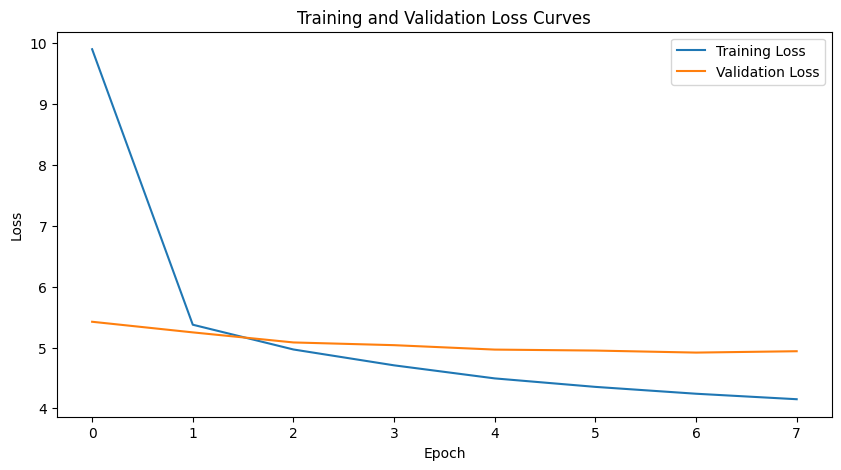

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curves')
#ax = plt.gca()
#ax.set_ylim([0, 300])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluate on test set

In [10]:
test_loss, test_mae = model.evaluate(test_dataset)

52/52 [==============================] - 6s 103ms/step - loss: 4.7506 - mae: 5.2276


Visualize the most significant errors

52/52 [==============================] - 6s 94ms/step


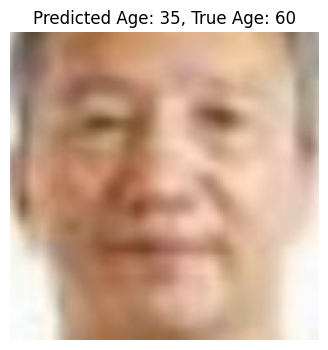

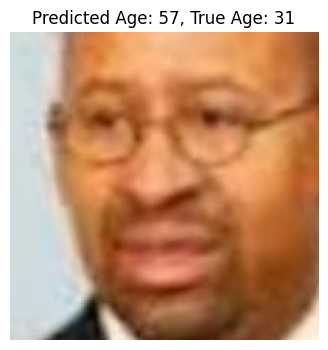

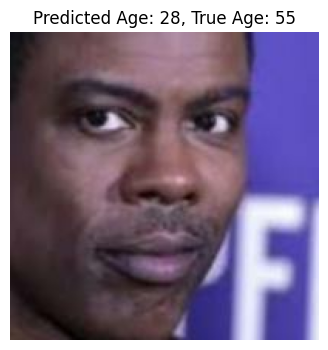

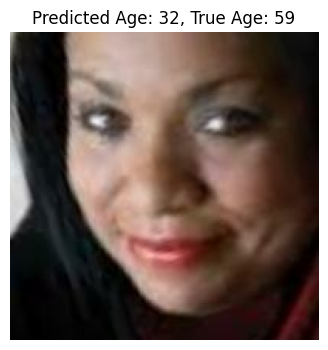

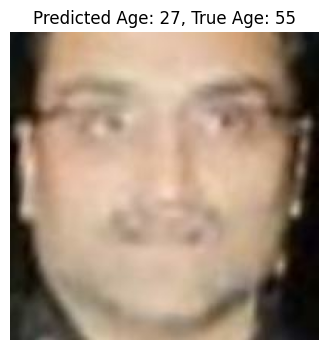

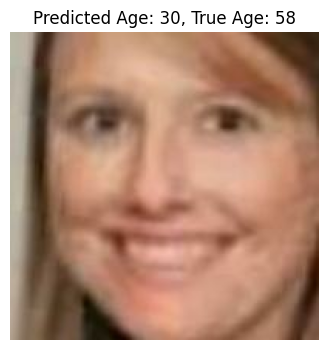

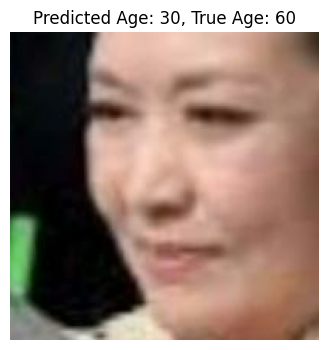

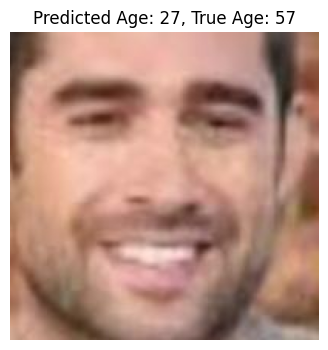

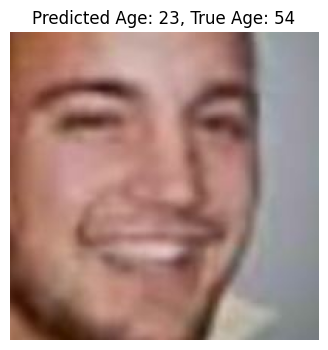

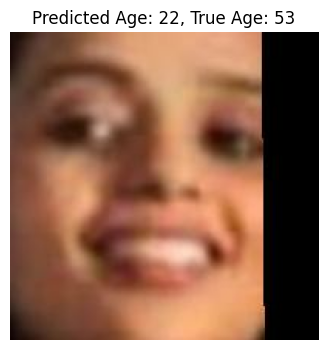

In [11]:
predictions = model.predict(test_dataset)
true_labels = []
test_images = []

for img_batch, lbl_batch in test_dataset.unbatch():
    true_labels.append(lbl_batch.numpy())
    test_images.append(img_batch.numpy())

true_labels = np.array(true_labels)
predictions = predictions.flatten()
test_images = np.stack(test_images)

errors = np.abs(predictions - true_labels)

biggest_errors_idx = np.argsort(errors)[-10:]

import matplotlib.pyplot as plt

for idx in biggest_errors_idx:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[idx].astype('uint8'))
    plt.title(f'Predicted Age: {int(predictions[idx])}, True Age: {true_labels[idx]}')
    plt.axis('off')
    plt.show()

Plot the age distribution of true vs. predicted values from the test set

52/52 [==============================] - 5s 93ms/step


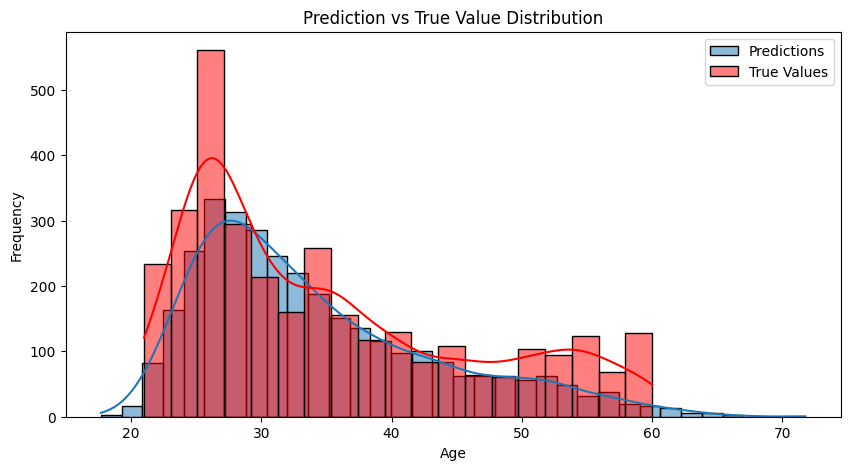

In [12]:
#y_pred = model.predict(test_dataset)
y_pred = model.predict(test_dataset)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

plt.figure(figsize=(10, 5))
sns.histplot(y_pred, kde=True, color='blue', label='Predictions')
sns.histplot(y_true, kde=True, color='red', label='True Values')
plt.title('Prediction vs True Value Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
y_train = np.concatenate([y for x, y in train_dataset], axis=0)
y_val = np.concatenate([y for x, y in val_dataset], axis=0)
y_val[30:55]

array([34, 12, 26, 43, 57, 26, 12, 30, 28, 60, 78, 43, 26,  4, 32, 52, 20,
       25, 22,  2, 29, 39, 27, 26, 30], dtype=int32)

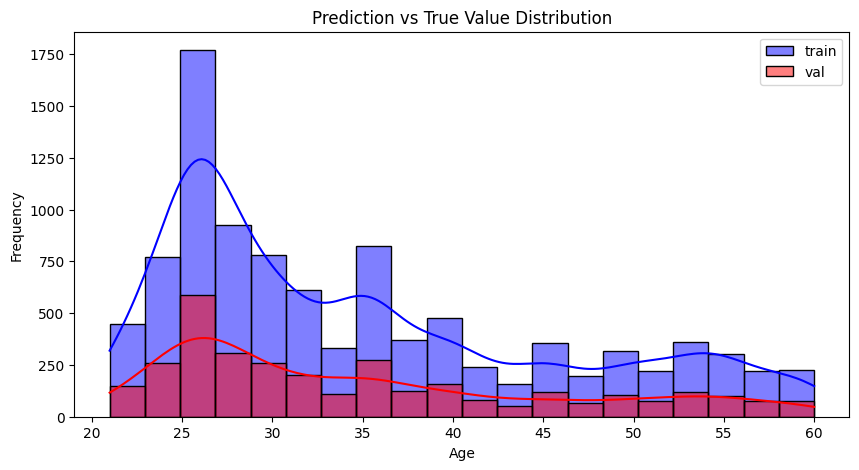

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(y_train, kde=True, color='blue', label='train', bins = 20)
sns.histplot(y_val, kde=True, color='red', label='val', bins = 20)
plt.title('Prediction vs True Value Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()